# Week 4: BBC News Classification Project
## DTSA 5510 - Intro to Machine Learning - Unsupervised

In [44]:
import pandas as pd
import numpy as np
import re
import nltk
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score



In [2]:
# downloads required to make this notebook run

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

In [3]:
# read in data
train_df = pd.read_csv('data/BBC News Train.csv')

train_df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### EDA & cleaning:

* remove duplicate text
* remove non-alphabetical characters
  
* tfidf_vectorizer
    * remove stop words
    * lemmatize 
    * tokenize text
    * plot scores

* non-negative matrix factorization models
    * Frobenius Loss
    * Kullback-Leibler Divergence 
    * plot top words per topic
* Compare to supervised learning model

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


There are no missing values in the data.

### Cleaning:

A uniform method is needed to preprocess the text in both the training and the testing data. 

In [7]:
# function to remove duplicates
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    # number of duplicates
    number_duplicates = df['Text'].duplicated().sum()

    # print no. duplicates
    print(f'No. of duplicate articles: {number_duplicates}' '\n')

    # removal
    df_cleaned = df.drop_duplicates(subset = ['Text'])

    return df_cleaned

# function to remove non-alphabetical characters
def remove_non_alpha(text):
    
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [8]:
train_df = remove_duplicates(train_df)
train_df['Text'] = train_df['Text'].apply(remove_non_alpha)
train_df.head(5)

No. of duplicate articles: 0



,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in m payout eighteen former enron...,business


Category
sport            0.237500
business         0.232639
politics         0.184722
entertainment    0.182639
tech             0.162500
Name: count, dtype: float64 



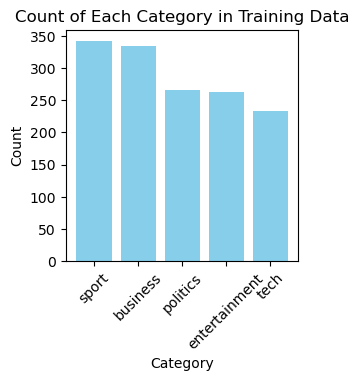

In [16]:
category_counts = train_df['Category'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

plt.figure(figsize=(3, 3))
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category in Training Data')
plt.xticks(rotation=45)
plt.show()

#### Baseline model 
A baseline to compare all models against would be the dummy predictor using most frequent. If sports were the most frequently occuring topic at almost 24%, and I predicted sports as the topic for all columns, I would be correct at least around 24% of the time, assuming a representative sample.

### Vectorization:

In [43]:
text = train_df['Text']

# specify vectorizer
vectorizer = (TfidfVectorizer(max_features = 1000, 
                              stop_words='english'))

# vectorize text col
train_tfidf = vectorizer.fit_transform(train_df['Text'])

# feature names
feature_names = vectorizer.get_feature_names_out()
#print(feature_names)



<function matplotlib.pyplot.show(close=None, block=None)>

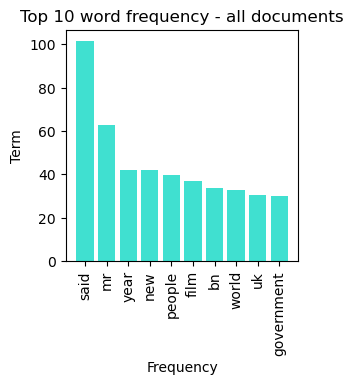

In [35]:
# word frequency - all documents
word_freq = np.sum(train_tfidf.toarray(), axis=0)
freq_all = pd.DataFrame({'Term': feature_names, 'Frequency': word_freq})
freq_all = freq_all.sort_values(by='Frequency', ascending=False)

# top 10
top_all = freq_all.head(10)


# plot
plt.figure(figsize=(3, 3))
bars = plt.bar(top_all['Term'], top_all['Frequency'], color = 'turquoise')

plt.xlabel('Frequency')
plt.ylabel('Term')
plt.title('Top 10 word frequency - all documents')
plt.xticks(rotation=90)
plt.show

['business' 'tech' 'politics' 'sport' 'entertainment']


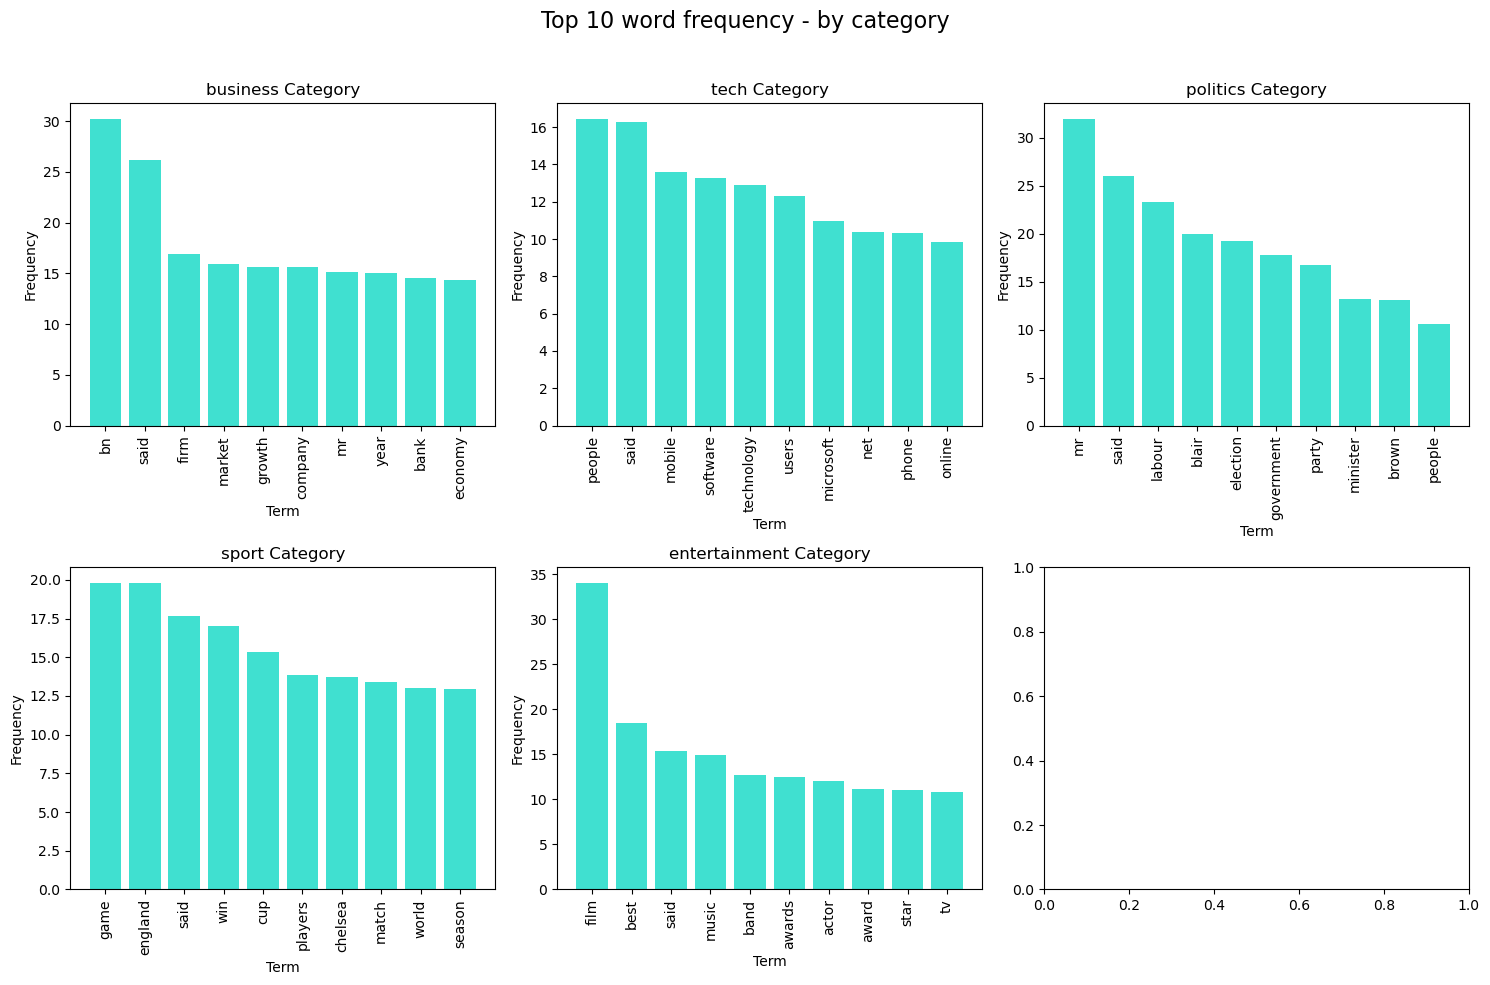

In [40]:
# subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Top 10 word frequency - by category', fontsize=16)

# word frequency - category
cat = train_df['Category'].unique()
print(cat)

# loop to create subplots
for i, category in enumerate(cat):
    
    # filter train_tfidf for category
    cat_class = train_df['Category'] == category
    cat_tfidf = train_tfidf[cat_class]

    # word freq
    word_freq = np.sum(cat_tfidf.toarray(), axis = 0)
    freq_df = pd.DataFrame({'Term': feature_names,
                            'Frequency': word_freq})
    freq_df = freq_df.sort_values(by = 'Frequency', ascending = False)

    # top10
    top_freq = freq_df.head(10)

    # subplot
    ax = axes[i // 3, i % 3]  # Map i to the 2x3 grid
    ax.bar(top_freq['Term'], top_freq['Frequency'], color='turquoise')
    ax.set_title(f'{category} Category')
    ax.set_xlabel('Term')
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### TF-IDF scores 

How important are these words in regards to the text? 
* The Tfidf scores tell us...
* How it works: The more frequent a word is in a document or article, the less important it becomes, therefor it's frequency has an inverse relationship to it's importance. An example of this in the data is the word 'said':
        *  'Said' is in the top 10 for all 5 categories. I suspect that  
* I'll use these scores to... remove some words from the data?

### Dimensionality reduction

Using NMF

In [14]:
# Initialize the NMF model
num_topics = 5  # Choose the number of topics
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit the model to the document-term matrix
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_


In [15]:
# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Print top terms for each topic
num_top_words = 10  # Number of top words to display for each topic
for topic_idx, topic in enumerate(H):
    top_terms_idx = topic.argsort()[-num_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx}:")
    print(" ".join(top_terms))
    print()


Topic 0:
said growth year market economy sales firm company shares bank

Topic 1:
game england win cup said wales players team ireland play

Topic 2:
film best awards award actor actress films oscar director star

Topic 3:
mr labour blair election said brown party government minister prime

Topic 4:
people mobile music said phone technology users software use digital



In [16]:
# Assign the topic with the highest score to each document
train_df['Topic'] = W.argmax(axis=1)

# Display the first few rows with assigned topics
train_df[['ArticleId', 'Category', 'Topic']].head()


,ArticleId,Category,Topic
0,1833,business,3
1,154,business,0
2,1101,business,0
3,1976,tech,4
4,917,business,0


In [41]:
# # pipeline framework# 
# 
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.model_selection import train_test_split
# 
# # Define your unsupervised models
# models = {
#     'KMeans': KMeans(n_clusters=3, random_state=2023),
#     'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
# }
# 
# results_dict = {}
# 
# # Split your data for evaluation
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=2023)[0]
# 
# for model_name, model in models.items():
#     print(model_name, ":")
# 
#     # Create a pipeline with preprocessing and model
#     model_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('model', model)
#     ])
#     
#     # Fit the model
#     model_pipeline.fit(X_train)
# 
#     # Predict clusters
#     if hasattr(model_pipeline.named_steps['model'], 'predict'):
#         clusters = model_pipeline.named_steps['model'].predict(X_test)
#     else:
#         clusters = model_pipeline.named_steps['model'].fit_predict(X_test)
# 
#     # Evaluate using silhouette score
#     score = silhouette_score(X_test, clusters)
# 
#     # Store results
#     results_dict[model_name] = {
#         'mean_silhouette_score': round(score, 4)
#     }
# 
# results_df = pd.DataFrame(results_dict).T
# print(results_df)

## References:

1. **ChatGPT.** Damn rights, I used it and not going to pretend I didn't! I already knew the structure of pipelines and preprocessors from previous ML classes (both at UC Boulder and elsewhere). I had written out code for the tokenization and thought - why don't I incorporate this into a pipeline? That's when I turned to AI for assistance. There was a lot of back and forth, because nothing ever worked the first (or 5th) time around. AI is a tool, not a crutch. I suppose a crutch _IS_ a tool, but I digress.  **TLDR; I used AI for assistance, NOT to do the work for me.**    
      
2. [**This Kaggle notebook**](https://www.kaggle.com/code/cjtayl31772/mini-project-part-1) for guidance.

3. [**SKLearn TfidfVectorizer documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for reference.

4. [**SKLearn NMF documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) for reference.

5. All course lectures, notebooks, examples, readings, and material etc. were heavily referenced throughout this entire notebook.